Copyright (c) 2022 Graphcore Ltd. All rights reserved.

# Temporal Graph Networks training
This notebook demonstrates how to train [Temporal Graph Networks](https://arxiv.org/abs/2006.10637)
(TGNs) on the IPU. See our [blog post](https://www.graphcore.ai/posts/accelerating-and-scaling-temporal-graph-networks-on-the-graphcore-ipu) for details on
performance and scaling.
TGN can be used to predict connections in a dynamically evolving graph. In this
application look at graphs that gain edges over time. A typical use case is a social
network where users for new connections over time, or a recommendation system new edges
represent an interaction of a user with a product or content.

![dynamic_graph.png](static/dynamic_graph.png)

In this notebook we apply TGN to the [JODIE Wikipedia dataset](https://snap.stanford.edu/jodie/),
a dynamic graph of 1,000 Wikipedia articles and 8,227 Wikipedia users. 157,474
time-stamped edges describe the interactions of users with articles.

## How to run this notebook


To run the Python version of this tutorial:

1. Download and install the Poplar SDK. Run the `enable.sh` scripts for Poplar
   and PopART as described in the [Getting
   Started](https://docs.graphcore.ai/en/latest/getting-started.html) guide for
   your IPU system.
2. For repeatability we recommend that you create and activate a Python virtual
   environment. You can do this with: a. create a virtual environment in the
   directory `venv`: `virtualenv -p python3 venv`; b. activate it: `source
   venv/bin/activate`.
3. Install the Python packages that this tutorial needs with `python -m pip
   install -r requirements.txt`.

To run the Jupyter notebook version of this tutorial:

1. Enable a Poplar SDK environment (see the [Getting
  Started](https://docs.graphcore.ai/en/latest/getting-started.html) guide for
  your IPU system)
2. In the same environment, install the Jupyter notebook server:
   `python -m pip install jupyter`
3. Launch a Jupyter Server on a specific port:
   `jupyter-notebook --no-browser --port <port number>`
4. Connect via SSH to your remote machine, forwarding your chosen port:
   `ssh -NL <port number>:localhost:<port number>
   <your username>@<remote machine>`

For more details about this process, or if you need troubleshooting, see our
[guide on using IPUs from Jupyter
notebooks](../../standard_tools/using_jupyter/README.md).

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
  Using cached examples_utils-0.0.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


## Load required dependencies

In [2]:
import tensorflow.compat.v1 as tf
from tensorflow.python import ipu
import numpy as np
import sklearn.metrics
import time
import matplotlib.pyplot as plt
from functools import partial

In [3]:
import dataloader
import model
import optimiser
import utils

## Configure the IPU system

In [4]:
config = ipu.config.IPUConfig()
config.auto_select_ipus = 1
config.floating_point_behaviour.esr = ipu.config.StochasticRoundingBehaviour.ON
config.floating_point_behaviour.oflo = True
config.floating_point_behaviour.inv = True
config.floating_point_behaviour.div0 = True
config.configure_ipu_system()

## Define the model
In addition to a single layer attention-based graph neural network (`tgn_gnn`) TGN
introduces a memory module (`tgn_memory`) that keeps track of past interaction of each
node.

![architecture.png](static/architecture.png)

Due to the dynamic nature of the graph lower batch sizes will yield a higher accuracy.
The hyperparameters `nodes_size` and `edges_size` control the padding of the tensors
that contain the relevant nodes/edges per batch. The optimal setting for these
hyperparameters depend on the batch size.

In [5]:
# Hyperparameters:

LEARNING_RATE = 1e-4
BATCH_SIZE = 40
NODES_SIZE = 500
EDGES_SIZE = 1200
EPOCHS = 50

In [6]:
def tgn(
    # Settings
    n_nodes: int,
    memory_size: int,
    time_embedding_size: int,
    dropout: float,
    learning_rate: float,
    is_training: bool,
    # Inputs
    node_ids: tf.Tensor,
    batch_idx: tf.Tensor,
    batch_times: tf.Tensor,
    batch_features: tf.Tensor,
    batch_most_recent: tf.Tensor,
    edge_idx: tf.Tensor,
    edge_times: tf.Tensor,
    edge_features: tf.Tensor,
):
    memory = model.tgn_memory(
        n_nodes=n_nodes,
        memory_size=memory_size,
        time_embedding_size=time_embedding_size,
        node_ids=node_ids,
        write_idx=batch_idx[:2],
        write_mask=batch_most_recent,
        write_features=batch_features,
        write_times=batch_times,
    )

    hidden = model.tgn_gnn(
        time_embedding_size=time_embedding_size,
        dropout=is_training * dropout,
        input=memory.output,
        last_update=memory.last_update,
        edge_idx=edge_idx,
        edge_times=edge_times,
        edge_features=edge_features,
    )

    logits = model.tgn_link_predictor(
        tf.gather(hidden, tf.tile(batch_idx[0][tf.newaxis], (2, 1))),
        tf.gather(hidden, batch_idx[1:]),
    )

    batch_mask = tf.not_equal(batch_idx[0], node_ids.shape[0] - 1)
    count = tf.reduce_sum(tf.cast(batch_mask, tf.int32))
    labels = tf.tile(tf.constant([[1], [0]], dtype=logits.dtype), (1, logits.shape[1]))

    # *2 because the reference uses mean(pos_loss) + mean(neg_loss)
    loss = 2 * tf.reduce_mean(
        tf.cast(batch_mask, logits.dtype)
        * tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    )

    if is_training:
        step = optimiser.Adam(learning_rate=learning_rate).minimize_with_global_step(
            loss
        )
        with tf.control_dependencies(memory.updates + (step,)):
            return dict(loss=tf.identity(loss), count=count)
    else:
        with tf.control_dependencies(memory.updates):
            return dict(
                loss=tf.identity(loss), count=count, probs=tf.nn.sigmoid(logits)
            )

## Create the dataloader and the training/validation loop
The first call to `dataloader.Data` will download, preprocess, and save the JODIE
Wikipedia dataset.

In [7]:
loader = dataloader.Data(
    "data/JODIE",
    dtype=np.float16,
    batch_size=BATCH_SIZE,
    nodes_size=NODES_SIZE,
    edges_size=EDGES_SIZE,
)

In [8]:
model_settings = dict(
    n_nodes=loader.data.num_nodes,
    memory_size=100,
    time_embedding_size=100,
    dropout=0.1,
    learning_rate=LEARNING_RATE,
)

In [9]:
with tf.Graph().as_default() as graph:
    runners = {}
    for part in ["train", "val"]:

        def modelfn(**args: tf.Tensor):
            with tf.variable_scope("model", reuse=part != "train"):
                return tgn(is_training=part == "train",
                           **model_settings,
                           **args)

        part_batches = loader.n_batches(part)
        dataset = loader.dataset(part).take(part_batches)
        runners[part] = utils.IpuLoopRunner(fn=modelfn,
                                            dataset=dataset,
                                            n_batch=part_batches)

    ipu.utils.move_variable_initialization_to_cpu()

    variables = {
        v.name: v
        for v in graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    }

    initialize_variables = tf.group([v.initializer for v in variables.values()])
    reset_memory = tf.group([
        v.initializer
        for v in graph.get_collection(model.TGN_MEMORY_VARIABLES_KEY)
    ])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
def stats(outputs):
    """Accumulate statistics from train/val/test batches."""
    total = 0
    loss = 0.0
    metrics_total = 0
    average_precision = 0.0
    roc_auc = 0.0

    for n_batch, output in enumerate(outputs):
        count = int(output["count"])
        total += count
        loss += count * float(output["loss"])
        if "probs" in output:
            labels = np.tile([[1], [0]], (1, output["probs"].shape[1])).flatten()
            probs = output["probs"].flatten()
            metrics_total += count
            average_precision += count * sklearn.metrics.average_precision_score(labels, probs)
            roc_auc += count * sklearn.metrics.roc_auc_score(labels, probs)

    result = dict(loss=loss / total)
    if metrics_total:
        result.update(
            average_precision=float(average_precision / metrics_total),
            roc_auc=float(roc_auc / metrics_total),
        )

    return result

## Run training and validation
Results are printed individually after each epoch.

In [11]:
def run(n_epoch):
    with tf.Session(graph=graph) as session:

        def epoch(n_epoch: int, part: str):
            outputs = runners[part](session)
            epoch_stats = stats(outputs)
            return dict(n_epoch=n_epoch, part=part, **epoch_stats)

        session.run(initialize_variables)
        for n in range(1, n_epoch + 1):
            session.run(reset_memory)
            yield epoch(n, "train")
            yield epoch(n, "val")

In [12]:
val_precision = []
for log in run(EPOCHS):
    for k, v in log.items():
        print(f"{k}: {round(v, 4) if type(v)==float else v}, ", end="")
    if log["part"] == "val":
        val_precision.append(log["average_precision"])
    print("\n", flush=True)

n_epoch: 1, part: train, loss: 0.7286, 

n_epoch: 1, part: val, loss: 0.5522, average_precision: 0.9552, roc_auc: 0.9553, 

n_epoch: 2, part: train, loss: 0.5271, 

n_epoch: 2, part: val, loss: 0.5051, average_precision: 0.9624, roc_auc: 0.9617, 

n_epoch: 3, part: train, loss: 0.464, 

n_epoch: 3, part: val, loss: 0.4372, average_precision: 0.9731, roc_auc: 0.9703, 

n_epoch: 4, part: train, loss: 0.4267, 

n_epoch: 4, part: val, loss: 0.4082, average_precision: 0.9759, roc_auc: 0.9731, 

n_epoch: 5, part: train, loss: 0.402, 

n_epoch: 5, part: val, loss: 0.387, average_precision: 0.9765, roc_auc: 0.9758, 

n_epoch: 6, part: train, loss: 0.3878, 

n_epoch: 6, part: val, loss: 0.3841, average_precision: 0.9774, roc_auc: 0.9761, 

n_epoch: 7, part: train, loss: 0.3825, 

n_epoch: 7, part: val, loss: 0.3871, average_precision: 0.9773, roc_auc: 0.976, 

n_epoch: 8, part: train, loss: 0.3724, 

n_epoch: 8, part: val, loss: 0.3604, average_precision: 0.981, roc_auc: 0.9788, 

n_epoch: 9, p

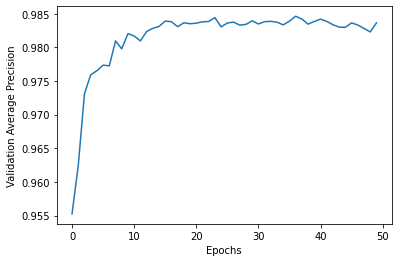

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[6,4])
ax.plot(val_precision)
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation Average Precision")
plt.show()

## Conclusion
In this tutorial we have learned about the architecture of Temporal Graph Networks.
We have used the IPU to accelerate training and inference and trained a TGN to SOTA
accuracy on the JODIE Wikipedia dataset.